In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 512) 
        self.fc0 = nn.Linear(512, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [41]:
#torch.manual_seed(7)

In [42]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58405/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58405/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [43]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58405/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_58405/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [44]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [45]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:01<00:00, 129.31it/s]


Epoch 0/100, Loss: 0.022610358893871307, train dataset accuracy: 80.31333333333333
test dataset accuracy: 91.1%


100%|██████████| 235/235 [00:01<00:00, 163.70it/s]


Epoch 1/100, Loss: 0.009436964988708496, train dataset accuracy: 91.425
test dataset accuracy: 91.62%


100%|██████████| 235/235 [00:01<00:00, 160.12it/s]


Epoch 2/100, Loss: 0.010446364991366863, train dataset accuracy: 92.17666666666666
test dataset accuracy: 92.8%


100%|██████████| 235/235 [00:01<00:00, 148.10it/s]


Epoch 3/100, Loss: 0.014338785782456398, train dataset accuracy: 92.45166666666667
test dataset accuracy: 92.87%


100%|██████████| 235/235 [00:01<00:00, 134.80it/s]


Epoch 4/100, Loss: 0.011682949028909206, train dataset accuracy: 92.41833333333334
test dataset accuracy: 92.73%


100%|██████████| 235/235 [00:01<00:00, 158.47it/s]


Epoch 5/100, Loss: 0.009867936372756958, train dataset accuracy: 92.67833333333333
test dataset accuracy: 92.56%


100%|██████████| 235/235 [00:01<00:00, 178.23it/s]


Epoch 6/100, Loss: 0.016867613419890404, train dataset accuracy: 92.75166666666667
test dataset accuracy: 92.59%


100%|██████████| 235/235 [00:01<00:00, 163.88it/s]


Epoch 7/100, Loss: 0.015604422427713871, train dataset accuracy: 92.7
test dataset accuracy: 92.6%


100%|██████████| 235/235 [00:01<00:00, 164.26it/s]


Epoch 8/100, Loss: 0.0115794213488698, train dataset accuracy: 92.86333333333333
test dataset accuracy: 93.01%


100%|██████████| 235/235 [00:01<00:00, 159.79it/s]


Epoch 9/100, Loss: 0.01126343384385109, train dataset accuracy: 92.72833333333334
test dataset accuracy: 92.88%


100%|██████████| 235/235 [00:01<00:00, 162.98it/s]


Epoch 10/100, Loss: 0.016095859929919243, train dataset accuracy: 93.02
test dataset accuracy: 92.89%


100%|██████████| 235/235 [00:01<00:00, 138.16it/s]


Epoch 11/100, Loss: 0.011839685961604118, train dataset accuracy: 92.985
test dataset accuracy: 93.17%


100%|██████████| 235/235 [00:01<00:00, 136.25it/s]


Epoch 12/100, Loss: 0.017142189666628838, train dataset accuracy: 93.05666666666667
test dataset accuracy: 92.7%


100%|██████████| 235/235 [00:02<00:00, 102.08it/s]


Epoch 13/100, Loss: 0.015467088669538498, train dataset accuracy: 92.94666666666667
test dataset accuracy: 93.45%


100%|██████████| 235/235 [00:01<00:00, 138.42it/s]


Epoch 14/100, Loss: 0.013138951733708382, train dataset accuracy: 93.17
test dataset accuracy: 93.21%


100%|██████████| 235/235 [00:01<00:00, 120.93it/s]


Epoch 15/100, Loss: 0.01325735542923212, train dataset accuracy: 92.8
test dataset accuracy: 92.84%


100%|██████████| 235/235 [00:02<00:00, 106.13it/s]


Epoch 16/100, Loss: 0.008465084247291088, train dataset accuracy: 93.08666666666667
test dataset accuracy: 92.84%


100%|██████████| 235/235 [00:02<00:00, 106.77it/s]


Epoch 17/100, Loss: 0.007913398556411266, train dataset accuracy: 93.175
test dataset accuracy: 93.59%


100%|██████████| 235/235 [00:01<00:00, 130.02it/s]


Epoch 18/100, Loss: 0.010599633678793907, train dataset accuracy: 93.07666666666667
test dataset accuracy: 93.14%


100%|██████████| 235/235 [00:01<00:00, 157.60it/s]


Epoch 19/100, Loss: 0.014058355242013931, train dataset accuracy: 93.115
test dataset accuracy: 92.08%


100%|██████████| 235/235 [00:01<00:00, 154.73it/s]


Epoch 20/100, Loss: 0.007684783544391394, train dataset accuracy: 92.915
test dataset accuracy: 92.61%


100%|██████████| 235/235 [00:01<00:00, 154.05it/s]


Epoch 21/100, Loss: 0.008697099052369595, train dataset accuracy: 93.04333333333334
test dataset accuracy: 93.26%


100%|██████████| 235/235 [00:01<00:00, 157.21it/s]


Epoch 22/100, Loss: 0.006039773114025593, train dataset accuracy: 93.3
test dataset accuracy: 92.8%


100%|██████████| 235/235 [00:01<00:00, 144.27it/s]


Epoch 23/100, Loss: 0.014278840273618698, train dataset accuracy: 93.285
test dataset accuracy: 92.42%


100%|██████████| 235/235 [00:01<00:00, 143.39it/s]


Epoch 24/100, Loss: 0.006089935544878244, train dataset accuracy: 93.10333333333334
test dataset accuracy: 91.95%


100%|██████████| 235/235 [00:01<00:00, 155.00it/s]


Epoch 25/100, Loss: 0.01029218640178442, train dataset accuracy: 93.36
test dataset accuracy: 92.72%


100%|██████████| 235/235 [00:01<00:00, 155.68it/s]


Epoch 26/100, Loss: 0.016179470345377922, train dataset accuracy: 92.76833333333333
test dataset accuracy: 93.06%


100%|██████████| 235/235 [00:01<00:00, 157.25it/s]


Epoch 27/100, Loss: 0.017833294346928596, train dataset accuracy: 93.04833333333333
test dataset accuracy: 92.8%


100%|██████████| 235/235 [00:01<00:00, 159.81it/s]


Epoch 28/100, Loss: 0.013826887123286724, train dataset accuracy: 93.175
test dataset accuracy: 92.41%


100%|██████████| 235/235 [00:01<00:00, 169.64it/s]


Epoch 29/100, Loss: 0.01239209994673729, train dataset accuracy: 92.68666666666667
test dataset accuracy: 92.15%


100%|██████████| 235/235 [00:01<00:00, 179.61it/s]


Epoch 30/100, Loss: 0.021658610552549362, train dataset accuracy: 92.77833333333334
test dataset accuracy: 92.34%


100%|██████████| 235/235 [00:01<00:00, 179.09it/s]


Epoch 31/100, Loss: 0.009464535862207413, train dataset accuracy: 92.90833333333333
test dataset accuracy: 93.19%


100%|██████████| 235/235 [00:01<00:00, 175.54it/s]


Epoch 32/100, Loss: 0.006663653068244457, train dataset accuracy: 93.06666666666666
test dataset accuracy: 92.67%


100%|██████████| 235/235 [00:01<00:00, 150.60it/s]


Epoch 33/100, Loss: 0.010100765153765678, train dataset accuracy: 93.43333333333334
test dataset accuracy: 92.55%


100%|██████████| 235/235 [00:01<00:00, 149.78it/s]


Epoch 34/100, Loss: 0.007610398344695568, train dataset accuracy: 93.07666666666667
test dataset accuracy: 92.55%


100%|██████████| 235/235 [00:01<00:00, 168.81it/s]


Epoch 35/100, Loss: 0.012291399762034416, train dataset accuracy: 93.435
test dataset accuracy: 93.49%


100%|██████████| 235/235 [00:01<00:00, 170.35it/s]


Epoch 36/100, Loss: 0.00869127456098795, train dataset accuracy: 93.13333333333334
test dataset accuracy: 92.33%


100%|██████████| 235/235 [00:01<00:00, 154.67it/s]


Epoch 37/100, Loss: 0.01137486007064581, train dataset accuracy: 93.26666666666667
test dataset accuracy: 92.91%


100%|██████████| 235/235 [00:01<00:00, 158.22it/s]


Epoch 38/100, Loss: 0.009167814627289772, train dataset accuracy: 93.51
test dataset accuracy: 93.01%


100%|██████████| 235/235 [00:01<00:00, 144.04it/s]


Epoch 39/100, Loss: 0.011434284970164299, train dataset accuracy: 93.57333333333334
test dataset accuracy: 93.38%


100%|██████████| 235/235 [00:01<00:00, 165.17it/s]


Epoch 40/100, Loss: 0.009504381567239761, train dataset accuracy: 93.63166666666666
test dataset accuracy: 92.71%


100%|██████████| 235/235 [00:01<00:00, 141.79it/s]


Epoch 41/100, Loss: 0.007953247055411339, train dataset accuracy: 93.575
test dataset accuracy: 93.42%


100%|██████████| 235/235 [00:01<00:00, 155.65it/s]


Epoch 42/100, Loss: 0.005506713408976793, train dataset accuracy: 93.32
test dataset accuracy: 93.32%


100%|██████████| 235/235 [00:01<00:00, 144.54it/s]


Epoch 43/100, Loss: 0.00895335990935564, train dataset accuracy: 93.6
test dataset accuracy: 93.78%


100%|██████████| 235/235 [00:02<00:00, 106.19it/s]


Epoch 44/100, Loss: 0.01644652523100376, train dataset accuracy: 93.54666666666667
test dataset accuracy: 90.42%


100%|██████████| 235/235 [00:02<00:00, 106.38it/s]


Epoch 45/100, Loss: 0.01049793977290392, train dataset accuracy: 92.97666666666667
test dataset accuracy: 93.45%


100%|██████████| 235/235 [00:01<00:00, 136.61it/s]


Epoch 46/100, Loss: 0.01647152192890644, train dataset accuracy: 93.78
test dataset accuracy: 92.61%


100%|██████████| 235/235 [00:01<00:00, 157.18it/s]


Epoch 47/100, Loss: 0.013705475255846977, train dataset accuracy: 93.275
test dataset accuracy: 91.86%


100%|██████████| 235/235 [00:01<00:00, 167.04it/s]


Epoch 48/100, Loss: 0.00906738918274641, train dataset accuracy: 93.05166666666666
test dataset accuracy: 93.03%


100%|██████████| 235/235 [00:01<00:00, 174.81it/s]


Epoch 49/100, Loss: 0.012146888300776482, train dataset accuracy: 93.48666666666666
test dataset accuracy: 93.58%


100%|██████████| 235/235 [00:01<00:00, 155.64it/s]


Epoch 50/100, Loss: 0.010656644590198994, train dataset accuracy: 93.70166666666667
test dataset accuracy: 93.2%


100%|██████████| 235/235 [00:01<00:00, 170.84it/s]


Epoch 51/100, Loss: 0.01343431044369936, train dataset accuracy: 93.36333333333333
test dataset accuracy: 93.41%


100%|██████████| 235/235 [00:01<00:00, 162.07it/s]


Epoch 52/100, Loss: 0.010027678683400154, train dataset accuracy: 93.59333333333333
test dataset accuracy: 93.36%


100%|██████████| 235/235 [00:01<00:00, 162.56it/s]


Epoch 53/100, Loss: 0.011472123675048351, train dataset accuracy: 93.58333333333333
test dataset accuracy: 93.77%


100%|██████████| 235/235 [00:01<00:00, 169.57it/s]


Epoch 54/100, Loss: 0.010236197151243687, train dataset accuracy: 93.42666666666666
test dataset accuracy: 92.98%


100%|██████████| 235/235 [00:01<00:00, 169.58it/s]


Epoch 55/100, Loss: 0.010937576182186604, train dataset accuracy: 93.81666666666666
test dataset accuracy: 93.02%


100%|██████████| 235/235 [00:01<00:00, 163.43it/s]


Epoch 56/100, Loss: 0.012356903403997421, train dataset accuracy: 93.86666666666666
test dataset accuracy: 93.21%


100%|██████████| 235/235 [00:01<00:00, 160.20it/s]


Epoch 57/100, Loss: 0.005208490416407585, train dataset accuracy: 94.02333333333333
test dataset accuracy: 93.73%


100%|██████████| 235/235 [00:01<00:00, 164.16it/s]


Epoch 58/100, Loss: 0.01189407054334879, train dataset accuracy: 93.655
test dataset accuracy: 92.67%


100%|██████████| 235/235 [00:01<00:00, 157.21it/s]


Epoch 59/100, Loss: 0.005941652227193117, train dataset accuracy: 93.69333333333333
test dataset accuracy: 93.11%


100%|██████████| 235/235 [00:01<00:00, 156.93it/s]


Epoch 60/100, Loss: 0.021583516150712967, train dataset accuracy: 93.78166666666667
test dataset accuracy: 93.09%


100%|██████████| 235/235 [00:01<00:00, 160.83it/s]


Epoch 61/100, Loss: 0.008630143478512764, train dataset accuracy: 93.57
test dataset accuracy: 93.29%


100%|██████████| 235/235 [00:01<00:00, 162.11it/s]


Epoch 62/100, Loss: 0.0062431711703538895, train dataset accuracy: 94.14
test dataset accuracy: 92.75%


100%|██████████| 235/235 [00:01<00:00, 172.84it/s]


Epoch 63/100, Loss: 0.014170057140290737, train dataset accuracy: 94.06833333333333
test dataset accuracy: 93.51%


100%|██████████| 235/235 [00:01<00:00, 155.75it/s]


Epoch 64/100, Loss: 0.01134078111499548, train dataset accuracy: 93.49166666666666
test dataset accuracy: 93.0%


100%|██████████| 235/235 [00:01<00:00, 154.13it/s]


Epoch 65/100, Loss: 0.008480207994580269, train dataset accuracy: 93.54
test dataset accuracy: 93.23%


100%|██████████| 235/235 [00:01<00:00, 171.02it/s]


Epoch 66/100, Loss: 0.015663066878914833, train dataset accuracy: 93.85333333333334
test dataset accuracy: 93.36%


100%|██████████| 235/235 [00:01<00:00, 167.74it/s]


Epoch 67/100, Loss: 0.014018643647432327, train dataset accuracy: 93.99
test dataset accuracy: 93.23%


100%|██████████| 235/235 [00:01<00:00, 151.87it/s]


Epoch 68/100, Loss: 0.00471100676804781, train dataset accuracy: 93.75166666666667
test dataset accuracy: 93.06%


100%|██████████| 235/235 [00:01<00:00, 152.44it/s]


Epoch 69/100, Loss: 0.0020851425360888243, train dataset accuracy: 93.965
test dataset accuracy: 93.37%


100%|██████████| 235/235 [00:01<00:00, 160.12it/s]


Epoch 70/100, Loss: 0.004766072612255812, train dataset accuracy: 94.095
test dataset accuracy: 93.4%


100%|██████████| 235/235 [00:01<00:00, 167.91it/s]


Epoch 71/100, Loss: 0.007891968823969364, train dataset accuracy: 94.12833333333333
test dataset accuracy: 92.81%


100%|██████████| 235/235 [00:01<00:00, 162.18it/s]


Epoch 72/100, Loss: 0.017394741997122765, train dataset accuracy: 94.415
test dataset accuracy: 93.79%


100%|██████████| 235/235 [00:01<00:00, 149.58it/s]


Epoch 73/100, Loss: 0.005877782125025988, train dataset accuracy: 94.21166666666667
test dataset accuracy: 93.53%


100%|██████████| 235/235 [00:01<00:00, 173.13it/s]


Epoch 74/100, Loss: 0.014653791673481464, train dataset accuracy: 94.06833333333333
test dataset accuracy: 93.03%


100%|██████████| 235/235 [00:01<00:00, 155.65it/s]


Epoch 75/100, Loss: 0.014593686908483505, train dataset accuracy: 93.88
test dataset accuracy: 93.26%


100%|██████████| 235/235 [00:01<00:00, 158.72it/s]


Epoch 76/100, Loss: 0.009939831681549549, train dataset accuracy: 93.96333333333334
test dataset accuracy: 93.15%


100%|██████████| 235/235 [00:01<00:00, 156.47it/s]


Epoch 77/100, Loss: 0.01451911497861147, train dataset accuracy: 93.82666666666667
test dataset accuracy: 93.14%


100%|██████████| 235/235 [00:01<00:00, 179.08it/s]


Epoch 78/100, Loss: 0.006378878373652697, train dataset accuracy: 93.8
test dataset accuracy: 93.17%


100%|██████████| 235/235 [00:01<00:00, 156.40it/s]


Epoch 79/100, Loss: 0.006900285370647907, train dataset accuracy: 93.83833333333334
test dataset accuracy: 93.07%


100%|██████████| 235/235 [00:01<00:00, 167.85it/s]


Epoch 80/100, Loss: 0.013661179691553116, train dataset accuracy: 94.21333333333334
test dataset accuracy: 93.36%


100%|██████████| 235/235 [00:01<00:00, 159.48it/s]


Epoch 81/100, Loss: 0.014763413928449154, train dataset accuracy: 94.17
test dataset accuracy: 92.84%


100%|██████████| 235/235 [00:01<00:00, 163.94it/s]


Epoch 82/100, Loss: 0.005303066689521074, train dataset accuracy: 94.21
test dataset accuracy: 93.84%


100%|██████████| 235/235 [00:01<00:00, 143.87it/s]


Epoch 83/100, Loss: 0.006846386007964611, train dataset accuracy: 94.26333333333334
test dataset accuracy: 92.61%


100%|██████████| 235/235 [00:01<00:00, 148.95it/s]


Epoch 84/100, Loss: 0.013669010251760483, train dataset accuracy: 94.41333333333333
test dataset accuracy: 93.3%


100%|██████████| 235/235 [00:01<00:00, 141.84it/s]


Epoch 85/100, Loss: 0.01116334181278944, train dataset accuracy: 94.17166666666667
test dataset accuracy: 93.26%


100%|██████████| 235/235 [00:01<00:00, 140.89it/s]


Epoch 86/100, Loss: 0.011698096990585327, train dataset accuracy: 94.15333333333334
test dataset accuracy: 93.38%


100%|██████████| 235/235 [00:01<00:00, 141.64it/s]


Epoch 87/100, Loss: 0.003602762473747134, train dataset accuracy: 94.325
test dataset accuracy: 93.85%


100%|██████████| 235/235 [00:01<00:00, 149.01it/s]


Epoch 88/100, Loss: 0.011277928948402405, train dataset accuracy: 93.92666666666666
test dataset accuracy: 93.3%


100%|██████████| 235/235 [00:01<00:00, 148.94it/s]


Epoch 89/100, Loss: 0.01725768856704235, train dataset accuracy: 94.21833333333333
test dataset accuracy: 93.66%


100%|██████████| 235/235 [00:01<00:00, 154.62it/s]


Epoch 90/100, Loss: 0.01297671813517809, train dataset accuracy: 94.31666666666666
test dataset accuracy: 93.52%


100%|██████████| 235/235 [00:01<00:00, 154.60it/s]


Epoch 91/100, Loss: 0.015271691605448723, train dataset accuracy: 93.83166666666666
test dataset accuracy: 93.27%


100%|██████████| 235/235 [00:01<00:00, 157.61it/s]


Epoch 92/100, Loss: 0.010534431785345078, train dataset accuracy: 93.92333333333333
test dataset accuracy: 93.48%


100%|██████████| 235/235 [00:01<00:00, 159.50it/s]


Epoch 93/100, Loss: 0.010835458524525166, train dataset accuracy: 94.36666666666666
test dataset accuracy: 93.33%


100%|██████████| 235/235 [00:01<00:00, 141.72it/s]


Epoch 94/100, Loss: 0.006434459704905748, train dataset accuracy: 94.52333333333333
test dataset accuracy: 93.76%


100%|██████████| 235/235 [00:01<00:00, 156.55it/s]


Epoch 95/100, Loss: 0.0037271790206432343, train dataset accuracy: 94.34
test dataset accuracy: 93.87%


100%|██████████| 235/235 [00:01<00:00, 160.64it/s]


Epoch 96/100, Loss: 0.005281747784465551, train dataset accuracy: 94.43
test dataset accuracy: 93.27%


100%|██████████| 235/235 [00:01<00:00, 161.39it/s]


Epoch 97/100, Loss: 0.011329177767038345, train dataset accuracy: 94.225
test dataset accuracy: 93.77%


100%|██████████| 235/235 [00:01<00:00, 141.97it/s]


Epoch 98/100, Loss: 0.007154462393373251, train dataset accuracy: 93.96666666666667
test dataset accuracy: 92.99%


100%|██████████| 235/235 [00:01<00:00, 158.57it/s]


Epoch 99/100, Loss: 0.009787539951503277, train dataset accuracy: 94.01333333333334
test dataset accuracy: 92.11%


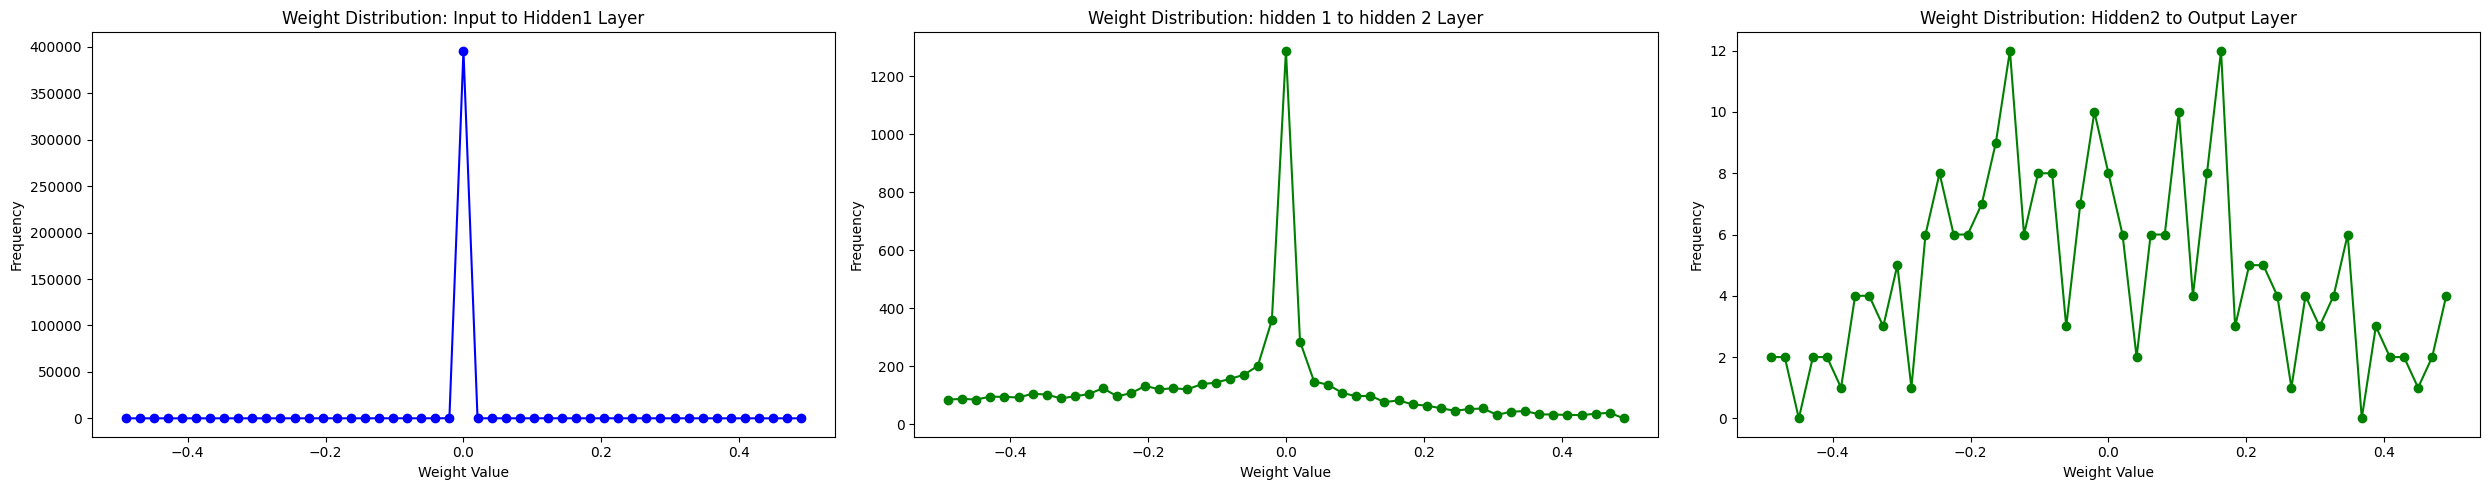

In [46]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [47]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 5667
Number of non-zero weights greater than 0.01 in layer 1: 6914
Number of non-zero weights greater than 0.01 in layer 3: 632


In [48]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.9785332388928175, 0.9795337796363723, 0.979518247776531, 0.9797695742032985, 0.9811448878184577, 0.9801294962635096, 0.9806524080453389, 0.9790627200364015, 0.9806085262684803, 0.9805608643903388, 0.9807560015953464, 0.9793388934145479, 0.9801715872785964, 0.9786705355131045, 0.9820482049585939, 0.9818333785292237, 0.9792533271180371, 0.9796090308415784, 0.9799264843147479, 0.9802277969705011, 0.9790384352590525, 0.9779656436142123, 0.979481077553055, 0.9793321149949716, 0.9798689409655564, 0.9818924909326409, 0.9812097301095887, 0.9790798454722626, 0.9803146331654545, 0.9788069528202482, 0.9795634006879164, 0.9788610693263641, 0.978268576033662, 0.9785570164476877, 0.9801301987132206, 0.9791523224823071, 0.9779185758119406, 0.979861464442297, 0.9806587228096899, 0.9778589495749355, 0.9791594361684517, 0.9791633255630043, 0.9800003434254527, 0.9805896132139958, 0.9810272352841986, 0.9803356827713758, 0.980099461761115, 0.9790500786517239, 0.9801546533663693, 0.9797230380216971, 0.97

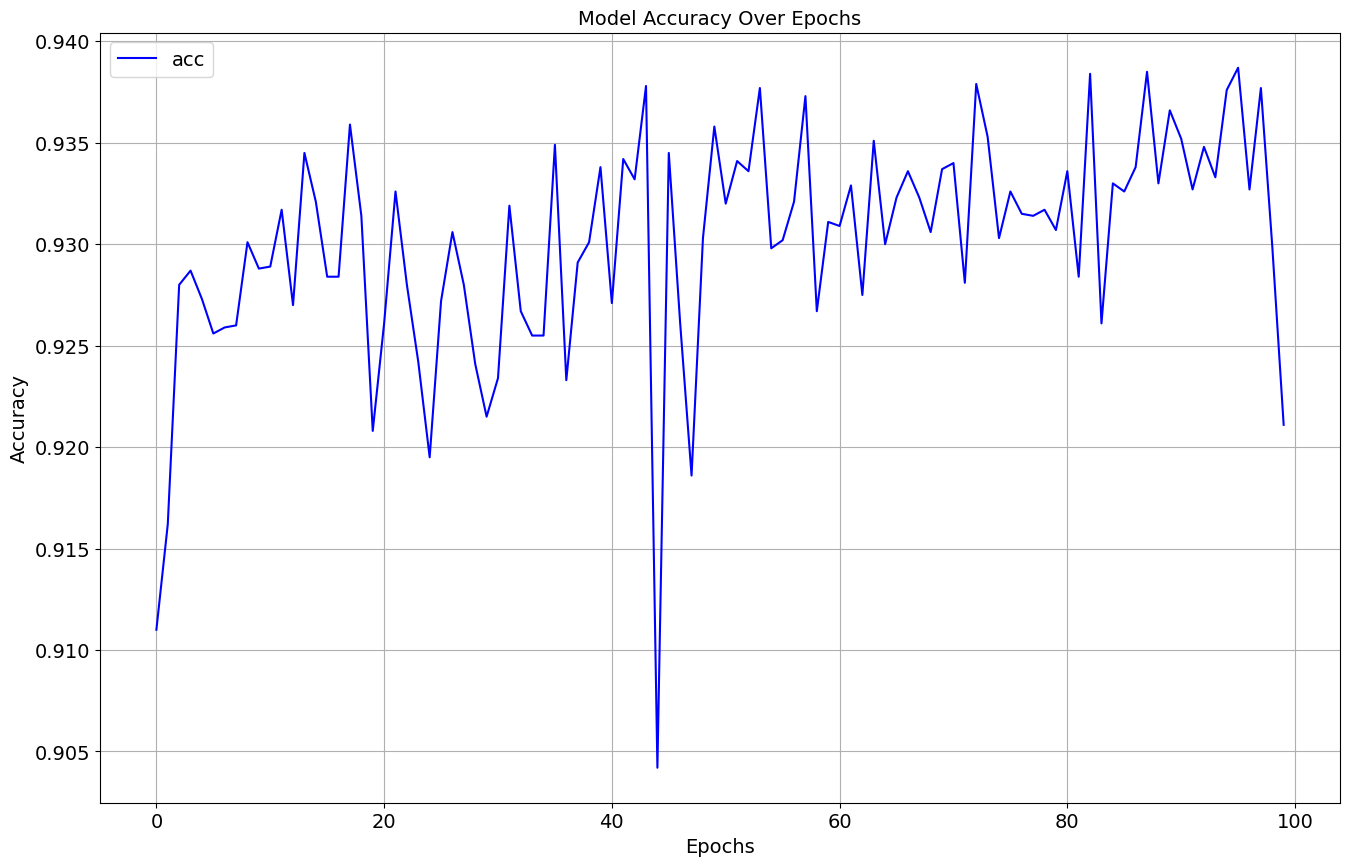

In [49]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [50]:
import pickle
with open('nbOnlineEveryEpochAcc4.pkl', 'wb') as f:
    pickle.dump(acc, f)